In [52]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
gamma = 0.5   # Cost unitary parameter
beta  = 0.5   # Mixing unitary parameter
n_qubits = 3  # Three qubits (labeled: x, y, z)
trotter_steps = 50

# --- Derived from the projector-decomposition ---
# (y,z) sector: H_yz = 2.5 + 1.5 Z_y + 1.0 Z_z
# (x,z) sector: H_xz = 1.5 + 0.5 Z_x + 1.0 Z_z
# (x,y) sector: H_xy = 2   + 0.5 Z_x + 1.5 Z_y
#
# Total (ignoring constants) becomes:
#   H_total = 1.0 Z_x + 3.0 Z_y + 2.0 Z_z
#
# In Qiskit, RZGate(theta) = exp(-i * theta/2 * Z),
# so to implement exp(-i * gamma * B * Z) we use theta = 2 * gamma * B.

# Create Quantum and Classical Registers
qr = QuantumRegister(n_qubits, name='q')
cr = ClassicalRegister(n_qubits, name='cr')
qc = QuantumCircuit(qr, cr)

# === STEP 1: Prepare a uniform superposition ===
for i in range(n_qubits):
    qc.h(qr[i])

# === STEP 2: Trotterized evolution ===
for step in range(trotter_steps):
    # --- Apply the Cost Unitary U_C(gamma) ---
    # Implement U_C ∝ exp(-i * gamma * (Z_x + 3 Z_y + 2 Z_z))
    # (Global phase exp(-i*gamma*6) is dropped.)
    qc.rz(2 * gamma * 1.0, qr[0])  # qubit x: 2*gamma*1.0
    qc.rz(2 * gamma * 3.0, qr[1])  # qubit y: 2*gamma*3.0
    qc.rz(2 * gamma * 2.0, qr[2])  # qubit z: 2*gamma*2.0
    
    # --- Apply the Mixing Unitary U_M(beta) ---
    for i in range(n_qubits):
        qc.rx(2 * beta, qr[i])

# === STEP 3: Measurement ===
qc.measure(qr, cr)

# Draw the circuit
#print(qc.draw())


{'111': 103, '100': 136, '010': 146, '101': 149, '110': 135, '011': 130, '001': 117, '000': 108}


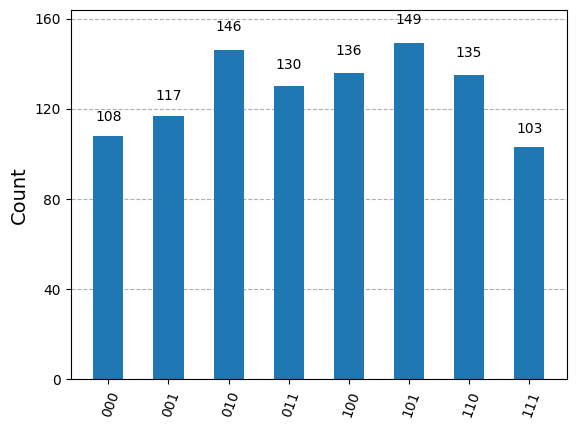

In [79]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

simulator = BasicSimulator()

# Simulate the circuit
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

# Print the counts
print(result.get_counts())

# Plot the histogram
plot_histogram(result.get_counts())

In [78]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Define parameters
gamma = 0.5          # Cost unitary parameter
beta = 0.1           # Mixing unitary parameter
T = 0.25             # Total evolution time
n_qubits = 3         # Number of qubits
trotter_steps = 10   # Number of Trotter steps

qr = QuantumRegister(n_qubits, 'q')
cr = ClassicalRegister(n_qubits, 'cr')
qc = QuantumCircuit(qr, cr)

for i in range(n_qubits):
    qc.h(qr[i])

qubit_index = {'x': 0, 'y': 1, 'z': 2}

tuples = [
    (0, [('y', -0.5), ('z', -0.5)]),
    (2, [('y', -0.5), ('z',  0.5)]),
    (3, [('y',  0.5), ('z', -0.5)]),
    (5, [('y',  0.5), ('z',  0.5)]),
    (0, [('x', -0.5), ('z', -0.5)]),
    (2, [('x', -0.5), ('z',  0.5)]),
    (1, [('x',  0.5), ('z', -0.5)]),
    (3, [('x',  0.5), ('z',  0.5)]),
    (0, [('x', -0.5), ('y', -0.5)]),
    (3, [('x', -0.5), ('y',  0.5)]),
    (1, [('x',  0.5), ('y', -0.5)]),
    (4, [('x',  0.5), ('y',  0.5)]),
]

# === Trotterized evolution ===
for step in range(trotter_steps):
    # --- Apply the Cost Unitary U_C(gamma) ---
    for tup in tuples:
        k, terms = tup
        n = len(terms)
        
        if n == 2:
            alpha = terms[0][1] + terms[1][1]
            total_coeff = 0
            qubit_pair = []
            for (qubit, coeff) in terms:
                total_coeff += alpha * coeff
                qubit_pair.append(qubit_index[qubit])
            theta = -2 * gamma * total_coeff * (T / trotter_steps)
            qc.rzz(theta, qr[qubit_pair[0]], qr[qubit_pair[1]])
        else:
            raise ValueError("Tuple with unsupported number of terms: {}".format(n))
    
    
    # --- Apply the Mixing Unitary U_M(beta) ---
    for i in range(n_qubits):
        qc.rx(2 * beta * (T / trotter_steps), qr[i])
        
qc.measure(qr, cr)



{'011': 111, '001': 138, '101': 144, '010': 149, '000': 128, '111': 120, '110': 110, '100': 124}


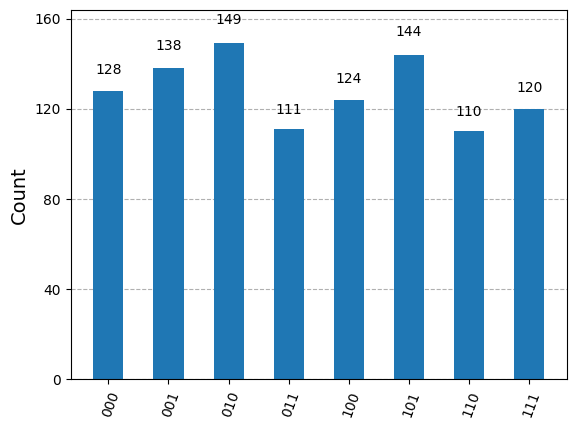

In [75]:
# Use the following code instead if you want to run on a simulator:
from qiskit_ibm_runtime.fake_provider import FakeKyiv
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

backend = FakeKyiv()

# Define Sampler
sampler = Sampler(mode=backend)

compiled_circuit = transpile(qc, backend)

# Run calculation
job = sampler.run([compiled_circuit], shots=1024)
 
result = job.result()

counts = result[0].data.cr.get_counts()

print(counts)

# Plot the histogram
plot_histogram(counts)